<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Intro to Bioinformatics in Python: Downloading and Annotating Genomic Sequences.</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM/CBE 480A5, Spring 2025
Instructor: Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



# Phylogenetic Trees

Phylogenetic trees, or *phylogenies*, are visual representations of evolutionary relationships.  Phylogenetic reconstruction can also provide additional information, such as the time at which events occurred, the population size through time, and mutation and migration rates.  

The data that you are comparing - in our case, this will be sequence data - represent the tips of a phylogenetic tree.  The tips are also referred to as the leaves, taxa, or extant nodes.  
The internal nodes, at which branching events occur, represent ancestors of multiple branches, or lineages.  
  
<img src="Figures/timetree.png" alt="alt text" width="49%" style="margin-right: 10px;"><img src="Figures/timetree_seq.png" alt="alt text" width="49%">

The branches of phylogenetic trees have different interpretations depending on the type of phylogeny you construct.  Two distinctly different types of phylogenetic trees are:  *model-based* trees and *distance-based* trees.  Two other important distinctions are:  *rooted* and *unrooted* trees.

A *rooted* tree has a starting point, or *root*.  An *unrooted* tree does not tell you which split, or branching event, in a tree occurred before any other.  It only shows which tips are more closely related to each other than which other tips.

<img src="Figures/timetree.png" alt="alt text" width="50%" style="margin-right: 100px;"><img src="Figures/disttree.png" alt="alt text" width="30%">

*Model-based trees* are constructed by modelling the process of evolution through time.  They allow us to do much more complex analyses and, in my opinion, more intuitively represent evolutionary history.  However, *distance trees* are much easier to understand and construct, so we will begin with them.

In [100]:
# %pip install biopython
# %pip install Bio
# %pip install git+https://github.com/neherlab/treetime.git
# conda install -c bioconda -c conda-forge treetime

import Bio
from Bio import Entrez, SeqIO, pairwise2, AlignIO, Phylo
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import ProtParam
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import webbrowser
import os
import threading

from Bio import Align
from Bio.Align import Alignment
from pymsaviz import MsaViz

# Function to find ORFs in all frames of a sequence
def find_all_orfs(sequence):
    orf_list = []           # List of all the ORF we find
    for frame in range(3):  # Check each of the three reading frames
        orfs = []           # List of ORFs for the current frame   
        lastStop = frame    # Position of last stop codon.
        for orf in sequence[frame:].translate(to_stop=False).split('*'):     # Translate the curent frame sequence into AA and break up by stop codons
            if len(orf) > 30:                                                # Consider ORFs longer than 50 amino acids
                start = lastStop + orf.find('M') * 3 if 'M' in orf else None # Update start codon position to next M, 
                stop = lastStop + (len(orf))*3 if 'M' in orf else None       # Update stop codon to next '*'
                if start is not None and stop is not None:                   # In the coding region is >30AA
                    orfs.append((start, stop))                                      # Append the start and stop positions for that ORF
            lastStop += len(orf)*3 + 3           # Update the position of the last stop codon
        orf_list.append(orfs)                    # Append the list of ORFs for the current frame
    return orf_list

def pickNLargestORF(orfs,N=5):
    Lengths = []
    Bounds = []
    for frame, orf in enumerate(orfs):
        for start, stop in orf:
            Lengths.append(stop-start)
            Bounds.append([start,stop])
    enumerated_list = list(enumerate(Lengths))
    sortedLengths = sorted(enumerated_list, key=lambda x: abs(x[1]), reverse=True)
    Bounds = [Bounds[index] for index, _ in sortedLengths[:N]]
    return Bounds

# Next, let's find the amino acid sequence for the largest open reading frame from each vaccine
def pickLargestORF(orfs):
    maxLength = 0;
    for frame, orfs in enumerate(orfs):
        for start, stop in orfs:
            if (stop-start)>maxLength:
                largestStart = start
                largestStop = stop
                maxLength = stop-start
            
    return largestStart, largestStop

In [101]:
# (ALIGNMENT) Lets try to align the virus sequence with the BioNTech/Phizer and Moderna vaccines
#      First, lets create the sequences for the two vacines from the following paper: 
#      https://github.com/NAalytics/Assemblies-of-putative-SARS-CoV2-spike-encoding-mRNA-sequences-for-
#          vaccines-BNT-162b2-and-mRNA-1273/blob/main/Assemblies%20of%20putative%20SARS-CoV2-spike-encoding
#          %20mRNA%20sequences%20for%20vaccines%20BNT-162b2%20and%20mRNA-1273.docx.pdf
BNT_Phizer = '''GAGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACCCGCCACCATGTTCGTGTTCCTGGTGCTGCTGCCTCTGGTGTCCA
GCCAGTGTGTGAACCTGACCACCAGAACACAGCTGCCTCCAGCCTACACCAACAGCTTTACCAGAGGCGTGTACTACCCCGACAAGGTGTT
CAGATCCAGCGTGCTGCACTCTACCCAGGACCTGTTCCTGCCTTTCTTCAGCAACGTGACCTGGTTCCACGCCATCCACGTGTCCGGCACC
AATGGCACCAAGAGATTCGACAACCCCGTGCTGCCCTTCAACGACGGGGTGTACTTTGCCAGCACCGAGAAGTCCAACATCATCAGAGGCT
GGATCTTCGGCACCACACTGGACAGCAAGACCCAGAGCCTGCTGATCGTGAACAACGCCACCAACGTGGTCATCAAAGTGTGCGAGTTCCA
GTTCTGCAACGACCCCTTCCTGGGCGTCTACTACCACAAGAACAACAAGAGCTGGATGGAAAGCGAGTTCCGGGTGTACAGCAGCGCCAAC
AACTGCACCTTCGAGTACGTGTCCCAGCCTTTCCTGATGGACCTGGAAGGCAAGCAGGGCAACTTCAAGAACCTGCGCGAGTTCGTGTTTA
AGAACATCGACGGCTACTTCAAGATCTACAGCAAGCACACCCCTATCAACCTCGTGCGGGATCTGCCTCAGGGCTTCTCTGCTCTGGAACC
CCTGGTGGATCTGCCCATCGGCATCAACATCACCCGGTTTCAGACACTGCTGGCCCTGCACAGAAGCTACCTGACACCTGGCGATAGCAGC
AGCGGATGGACAGCTGGTGCCGCCGCTTACTATGTGGGCTACCTGCAGCCTAGAACCTTCCTGCTGAAGTACAACGAGAACGGCACCATCA
CCGACGCCGTGGATTGTGCTCTGGATCCTCTGAGCGAGACAAAGTGCACCCTGAAGTCCTTCACCGTGGAAAAGGGCATCTACCAGACCAG
CAACTTCCGGGTGCAGCCCACCGAATCCATCGTGCGGTTCCCCAATATCACCAATCTGTGCCCCTTCGGCGAGGTGTTCAATGCCACCAGA
TTCGCCTCTGTGTACGCCTGGAACCGGAAGCGGATCAGCAATTGCGTGGCCGACTACTCCGTGCTGTACAACTCCGCCAGCTTCAGCACCT
TCAAGTGCTACGGCGTGTCCCCTACCAAGCTGAACGACCTGTGCTTCACAAACGTGTACGCCGACAGCTTCGTGATCCGGGGAGATGAAGT
GCGGCAGATTGCCCCTGGACAGACAGGCAAGATCGCCGACTACAACTACAAGCTGCCCGACGACTTCACCGGCTGTGTGATTGCCTGGAAC
AGCAACAACCTGGACTCCAAAGTCGGCGGCAACTACAATTACCTGTACCGGCTGTTCCGGAAGTCCAATCTGAAGCCCTTCGAGCGGGACA
TCTCCACCGAGATCTATCAGGCCGGCAGCACCCCTTGTAACGGCGTGGAAGGCTTCAACTGCTACTTCCCACTGCAGTCCTACGGCTTTCA
GCCCACAAATGGCGTGGGCTATCAGCCCTACAGAGTGGTGGTGCTGAGCTTCGAACTGCTGCATGCCCCTGCCACAGTGTGCGGCCCTAAG
AAAAGCACCAATCTCGTGAAGAACAAATGCGTGAACTTCAACTTCAACGGCCTGACCGGCACCGGCGTGCTGACAGAGAGCAACAAGAAGT
TCCTGCCATTCCAGCAGTTTGGCCGGGATATCGCCGATACCACAGACGCCGTTAGAGATCCCCAGACACTGGAAATCCTGGACATCACCCC
TTGCAGCTTCGGCGGAGTGTCTGTGATCACCCCTGGCACCAACACCAGCAATCAGGTGGCAGTGCTGTACCAGGACGTGAACTGTACCGAA
GTGCCCGTGGCCATTCACGCCGATCAGCTGACACCTACATGGCGGGTGTACTCCACCGGCAGCAATGTGTTTCAGACCAGAGCCGGCTGTC
TGATCGGAGCCGAGCACGTGAACAATAGCTACGAGTGCGACATCCCCATCGGCGCTGGAATCTGCGCCAGCTACCAGACACAGACAAACAG
CCCTCGGAGAGCCAGAAGCGTGGCCAGCCAGAGCATCATTGCCTACACAATGTCTCTGGGCGCCGAGAACAGCGTGGCCTACTCCAACAAC
TCTATCGCTATCCCCACCAACTTCACCATCAGCGTGACCACAGAGATCCTGCCTGTGTCCATGACCAAGACCAGCGTGGACTGCACCATGT
ACATCTGCGGCGATTCCACCGAGTGCTCCAACCTGCTGCTGCAGTACGGCAGCTTCTGCACCCAGCTGAATAGAGCCCTGACAGGGATCGC
CGTGGAACAGGACAAGAACACCCAAGAGGTGTTCGCCCAAGTGAAGCAGATCTACAAGACCCCTCCTATCAAGGACTTCGGCGGCTTCAAT
TTCAGCCAGATTCTGCCCGATCCTAGCAAGCCCAGCAAGCGGAGCTTCATCGAGGACCTGCTGTTCAACAAAGTGACACTGGCCGACGCCG
GCTTCATCAAGCAGTATGGCGATTGTCTGGGCGACATTGCCGCCAGGGATCTGATTTGCGCCCAGAAGTTTAACGGACTGACAGTGCTGCC
TCCTCTGCTGACCGATGAGATGATCGCCCAGTACACATCTGCCCTGCTGGCCGGCACAATCACAAGCGGCTGGACATTTGGAGCAGGCGCC
GCTCTGCAGATCCCCTTTGCTATGCAGATGGCCTACCGGTTCAACGGCATCGGAGTGACCCAGAATGTGCTGTACGAGAACCAGAAGCTGA
TCGCCAACCAGTTCAACAGCGCCATCGGCAAGATCCAGGACAGCCTGAGCAGCACAGCAAGCGCCCTGGGAAAGCTGCAGGACGTGGTCAA
CCAGAATGCCCAGGCACTGAACACCCTGGTCAAGCAGCTGTCCTCCAACTTCGGCGCCATCAGCTCTGTGCTGAACGATATCCTGAGCAGA
CTGGACCCTCCTGAGGCCGAGGTGCAGATCGACAGACTGATCACAGGCAGACTGCAGAGCCTCCAGACATACGTGACCCAGCAGCTGATCA
GAGCCGCCGAGATTAGAGCCTCTGCCAATCTGGCCGCCACCAAGATGTCTGAGTGTGTGCTGGGCCAGAGCAAGAGAGTGGACTTTTGCGG
CAAGGGCTACCACCTGATGAGCTTCCCTCAGTCTGCCCCTCACGGCGTGGTGTTTCTGCACGTGACATATGTGCCCGCTCAAGAGAAGAAT
TTCACCACCGCTCCAGCCATCTGCCACGACGGCAAAGCCCACTTTCCTAGAGAAGGCGTGTTCGTGTCCAACGGCACCCATTGGTTCGTGA
CACAGCGGAACTTCTACGAGCCCCAGATCATCACCACCGACAACACCTTCGTGTCTGGCAACTGCGACGTCGTGATCGGCATTGTGAACAA
TACCGTGTACGACCCTCTGCAGCCCGAGCTGGACAGCTTCAAAGAGGAACTGGACAAGTACTTTAAGAACCACACAAGCCCCGACGTGGAC
CTGGGCGATATCAGCGGAATCAATGCCAGCGTCGTGAACATCCAGAAAGAGATCGACCGGCTGAACGAGGTGGCCAAGAATCTGAACGAGA
GCCTGATCGACCTGCAAGAACTGGGGAAGTACGAGCAGTACATCAAGTGGCCCTGGTACATCTGGCTGGGCTTTATCGCCGGACTGATTGC
CATCGTGATGGTCACAATCATGCTGTGTTGCATGACCAGCTGCTGTAGCTGCCTGAAGGGCTGTTGTAGCTGTGGCAGCTGCTGCAAGTTC
GACGAGGACGATTCTGAGCCCGTGCTGAAGGGCGTGAAACTGCACTACACATGATGACTCGAGCTGGTACTGCATGCACGCAATGCTAGCT
GCCCCTTTCCCGTCCTGGGTACCCCGAGTCTCCCCCGACCTCGGGTCCCAGGTATGCTCCCACCTCCACCTGCCCCACTCACCACCTCTGC
TAGTTCCAGACACCTCCCAAGCACGCAGCAATGCAGCTCAAAACGCTTAGCCTAGCCACACCCCCACGGGAAACAGCAGTGATTAACCTTT
AGCAATAAACGAAAGTTTAACTAAGCTATACTAACCCCAGGGTTGGTCAATTTCGTGCCAGCCACACCCTGGAGCTAGCA'''
BNT_Phizer = BNT_Phizer.replace("\n", "")

Moderna = '''GGGAAATAAGAGAGAAAAGAAGAGTAAGAAGAAATATAAGACCCCGGCGCCGCCACCATGTTCGTGTTCCTGGTGCTGCTGCCCCTGGTGA
GCAGCCAGTGCGTGAACCTGACCACCCGGACCCAGCTGCCACCAGCCTACACCAACAGCTTCACCCGGGGCGTCTACTACCCCGACAAGGT
GTTCCGGAGCAGCGTCCTGCACAGCACCCAGGACCTGTTCCTGCCCTTCTTCAGCAACGTGACCTGGTTCCACGCCATCCACGTGAGCGGC
ACCAACGGCACCAAGCGGTTCGACAACCCCGTGCTGCCCTTCAACGACGGCGTGTACTTCGCCAGCACCGAGAAGAGCAACATCATCCGGG
GCTGGATCTTCGGCACCACCCTGGACAGCAAGACCCAGAGCCTGCTGATCGTGAATAACGCCACCAACGTGGTGATCAAGGTGTGCGAGTT
CCAGTTCTGCAACGACCCCTTCCTGGGCGTGTACTACCACAAGAACAACAAGAGCTGGATGGAGAGCGAGTTCCGGGTGTACAGCAGCGCC
AACAACTGCACCTTCGAGTACGTGAGCCAGCCCTTCCTGATGGACCTGGAGGGCAAGCAGGGCAACTTCAAGAACCTGCGGGAGTTCGTGT
TCAAGAACATCGACGGCTACTTCAAGATCTACAGCAAGCACACCCCAATCAACCTGGTGCGGGATCTGCCCCAGGGCTTCTCAGCCCTGGA
GCCCCTGGTGGACCTGCCCATCGGCATCAACATCACCCGGTTCCAGACCCTGCTGGCCCTGCACCGGAGCTACCTGACCCCAGGCGACAGC
AGCAGCGGGTGGACAGCAGGCGCGGCTGCTTACTACGTGGGCTACCTGCAGCCCCGGACCTTCCTGCTGAAGTACAACGAGAACGGCACCA
TCACCGACGCCGTGGACTGCGCCCTGGACCCTCTGAGCGAGACCAAGTGCACCCTGAAGAGCTTCACCGTGGAGAAGGGCATCTACCAGAC
CAGCAACTTCCGGGTGCAGCCCACCGAGAGCATCGTGCGGTTCCCCAACATCACCAACCTGTGCCCCTTCGGCGAGGTGTTCAACGCCACC
CGGTTCGCCAGCGTGTACGCCTGGAACCGGAAGCGGATCAGCAACTGCGTGGCCGACTACAGCGTGCTGTACAACAGCGCCAGCTTCAGCA
CCTTCAAGTGCTACGGCGTGAGCCCCACCAAGCTGAACGACCTGTGCTTCACCAACGTGTACGCCGACAGCTTCGTGATCCGTGGCGACGA
GGTGCGGCAGATCGCACCCGGCCAGACAGGCAAGATCGCCGACTACAACTACAAGCTGCCCGACGACTTCACCGGCTGCGTGATCGCCTGG
AACAGCAACAACCTCGACAGCAAGGTGGGCGGCAACTACAACTACCTGTACCGGCTGTTCCGGAAGAGCAACCTGAAGCCCTTCGAGCGGG
ACATCAGCACCGAGATCTACCAAGCCGGCTCCACCCCTTGCAACGGCGTGGAGGGCTTCAACTGCTACTTCCCTCTGCAGAGCTACGGCTT
CCAGCCCACCAACGGCGTGGGCTACCAGCCCTACCGGGTGGTGGTGCTGAGCTTCGAGCTGCTGCACGCCCCAGCCACCGTGTGTGGCCCC
AAGAAGAGCACCAACCTGGTGAAGAACAAGTGCGTGAACTTCAACTTCAACGGCCTTACCGGCACCGGCGTGCTGACCGAGAGCAACAAGA
AATTCCTGCCCTTTCAGCAGTTCGGCCGGGACATCGCCGACACCACCGACGCTGTGCGGGATCCCCAGACCCTGGAGATCCTGGACATCAC
CCCTTGCAGCTTCGGCGGCGTGAGCGTGATCACCCCAGGCACCAACACCAGCAACCAGGTGGCCGTGCTGTACCAGGACGTGAACTGCACC
GAGGTGCCCGTGGCCATCCACGCCGACCAGCTGACACCCACCTGGCGGGTCTACAGCACCGGCAGCAACGTGTTCCAGACCCGGGCCGGTT
GCCTGATCGGCGCCGAGCACGTGAACAACAGCTACGAGTGCGACATCCCCATCGGCGCCGGCATCTGTGCCAGCTACCAGACCCAGACCAA
TTCACCCCGGAGGGCAAGGAGCGTGGCCAGCCAGAGCATCATCGCCTACACCATGAGCCTGGGCGCCGAGAACAGCGTGGCCTACAGCAAC
AACAGCATCGCCATCCCCACCAACTTCACCATCAGCGTGACCACCGAGATTCTGCCCGTGAGCATGACCAAGACCAGCGTGGACTGCACCA
TGTACATCTGCGGCGACAGCACCGAGTGCAGCAACCTGCTGCTGCAGTACGGCAGCTTCTGCACCCAGCTGAACCGGGCCCTGACCGGCAT
CGCCGTGGAGCAGGACAAGAACACCCAGGAGGTGTTCGCCCAGGTGAAGCAGATCTACAAGACCCCTCCCATCAAGGACTTCGGCGGCTTC
AACTTCAGCCAGATCCTGCCCGACCCCAGCAAGCCCAGCAAGCGGAGCTTCATCGAGGACCTGCTGTTCAACAAGGTGACCCTAGCCGACG
CCGGCTTCATCAAGCAGTACGGCGACTGCCTCGGCGACATAGCCGCCCGGGACCTGATCTGCGCCCAGAAGTTCAACGGCCTGACCGTGCT
GCCTCCCCTGCTGACCGACGAGATGATCGCCCAGTACACCAGCGCCCTGTTAGCCGGAACCATCACCAGCGGCTGGACTTTCGGCGCTGGA
GCCGCTCTGCAGATCCCCTTCGCCATGCAGATGGCCTACCGGTTCAACGGCATCGGCGTGACCCAGAACGTGCTGTACGAGAACCAGAAGC
TGATCGCCAACCAGTTCAACAGCGCCATCGGCAAGATCCAGGACAGCCTGAGCAGCACCGCTAGCGCCCTGGGCAAGCTGCAGGACGTGGT
GAACCAGAACGCCCAGGCCCTGAACACCCTGGTGAAGCAGCTGAGCAGCAACTTCGGCGCCATCAGCAGCGTGCTGAACGACATCCTGAGC
CGGCTGGACCCTCCCGAGGCCGAGGTGCAGATCGACCGGCTGATCACTGGCCGGCTGCAGAGCCTGCAGACCTACGTGACCCAGCAGCTGA
TCCGGGCCGCCGAGATTCGGGCCAGCGCCAACCTGGCCGCCACCAAGATGAGCGAGTGCGTGCTGGGCCAGAGCAAGCGGGTGGACTTCTG
CGGCAAGGGCTACCACCTGATGAGCTTTCCCCAGAGCGCACCCCACGGAGTGGTGTTCCTGCACGTGACCTACGTGCCCGCCCAGGAGAAG
AACTTCACCACCGCCCCAGCCATCTGCCACGACGGCAAGGCCCACTTTCCCCGGGAGGGCGTGTTCGTGAGCAACGGCACCCACTGGTTCG
TGACCCAGCGGAACTTCTACGAGCCCCAGATCATCACCACCGACAACACCTTCGTGAGCGGCAACTGCGACGTGGTGATCGGCATCGTGAA
CAACACCGTGTACGATCCCCTGCAGCCCGAGCTGGACAGCTTCAAGGAGGAGCTGGACAAGTACTTCAAGAATCACACCAGCCCCGACGTG
GACCTGGGCGACATCAGCGGCATCAACGCCAGCGTGGTGAACATCCAGAAGGAGATCGATCGGCTGAACGAGGTGGCCAAGAACCTGAACG
AGAGCCTGATCGACCTGCAGGAGCTGGGCAAGTACGAGCAGTACATCAAGTGGCCCTGGTACATCTGGCTGGGCTTCATCGCCGGCCTGAT
CGCCATCGTGATGGTGACCATCATGCTGTGCTGCATGACCAGCTGCTGCAGCTGCCTGAAGGGCTGTTGCAGCTGCGGCAGCTGCTGCAAG
TTCGACGAGGACGACAGCGAGCCCGTGCTGAAGGGCGTGAAGCTGCACTACACCTGATAATAGGCTGGAGCCTCGGTGGCCTAGCTTCTTG
CCCCTTGGGCCTCCCCCCAGCCCCTCCTCCCCTTCCTGCACCCGTACCCCCGTGGTCTTTGAATAAAGTCTGAGTGGGCGGCAAAAAAAAA'''

Moderna = Moderna.replace("\n", "")

In [102]:
#(PRELIMINARIES) Let's download the COVID19 virus sequence from NCBI
# Provide your email for accessing NCBI
Entrez.email = "brian.munsky@colostate.edu"  # Insert your email here

def get_genbank(accession_number):
    handle = Entrez.efetch(db="nucleotide", id=accession_number, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()
    return record

corona_virus = get_genbank("MN908947")

# Exploring Evolutionary History of Multiple Sequences
To understand the evolutionary history of sequences, we can make phylogenetic trees. Let's try that with our BLAST results from before.

In [35]:
def makeTree(alignedFile):
    # read our alignment file.
    align = AlignIO.read(alignedFile, 'fasta')

    # define sequence distance metric
    calculator = DistanceCalculator('identity')
    dm  = calculator.get_distance(align)

    # construct tree
    constructor = DistanceTreeConstructor()
    return constructor.upgma(dm), dm

In [ ]:
# We will use the alignment file that we found in the last lesson:
alignedFile = "blast_file_aligned.afa"

tree, dm = makeTree(alignedFile)

# plot tree
fig, ax = plt.subplots(figsize=(8, 30))  # Adjust size as needed
Phylo.draw(tree,axes=ax)
Phylo.draw_ascii(tree)

In [ ]:
# The numerical distances can be found in the distance matrix "dm"
print(dm)

print(f'The phylogenetic distance between {dm.names[0]} and {dm.names[4]} is {dm[0,4]}')
print(f'The phylogenetic distance between {dm.names[1]} and {dm.names[4]} is {dm[1,4]}')

### 3.A) Explore different Covid variants.

Let's focus our analysis a little more closely onto some famous variants that were in the news during the early stages of the COVID19 pandemic:

In [ ]:
# Create a dictionary to map the sequence IDs to the sequence names
variantDict = {"wuhan":'MN908947',
            "delta":'OK091006',
            "beta":'MZ433432',
            "alpha":'MZ773928',
            "omicron":'PP028445',
            "OP208953":'OP208953',
            "MT628218":'MT628218'}

sequenceEntry = {}
for variant in variantDict:
    print(f"Downloading {variant} variant using accession number {variantDict[variant]}")
    sequenceEntry[variant] = get_genbank(variantDict[variant])
    # sequenceEntry.append(get_genbank(variantDict[variant]))

Let's also add the original Moderna vaccine to the mix so we can see what sequence it was most similar to.

In [ ]:
Moderna_orf_positions = find_all_orfs(Seq(Moderna))

Next, we will use a loop to write the protein sequences of all the different variants into a single FASTA file.  Note how we are including both the name and accession number varantDict[variant] and the translated sequence in each entry. 

In [40]:
variant_file_fasta = "covid_variants.fa"
with open(variant_file_fasta, "w") as handle:
    for variant in variantDict:
        # Find and record the third largest ORF for each sequence
        orf_positions = find_all_orfs(sequenceEntry[variant].seq)
        longestORFbounds = pickNLargestORF(orf_positions,5)
        proteinOfInterest = sequenceEntry[variant].seq[longestORFbounds[2][0]:].translate(to_stop=True)
        handle.write(f">{variant}:{variantDict[variant]}\n{proteinOfInterest}\n")
    startMod, stopMod = pickLargestORF(Moderna_orf_positions)
    proteinOfInterest = Seq(Moderna[startMod:stopMod]).translate(to_stop=True)
    handle.write(f">Moderna\n{proteinOfInterest}\n")


In [ ]:
# Now that we have a fasta file, we can run MUSCLE again to 
# compute and plot its alignment:
alignedFile = "covid_variants_aligned.afa"

# Use a terminal command (bash) to run MUSCLE in to align the sequences.        
bashCommand = "muscle -align " + variant_file_fasta + " -output " + alignedFile
os.system(bashCommand)

In [ ]:
# Make and save an alignment figure
mv = MsaViz(alignedFile, wrap_length=150, show_count=True)
mv.savefig("Variant_Alignment.png")

# Load the image
img = mpimg.imread('Variant_Alignment.png')

# Display the image
fig = plt.figure(figsize=(80, 80), dpi=200)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
# Compute the phylogenetic tree using our previous function:
tree = makeTree(alignedFile)
# plot tree
Phylo.draw_ascii(tree[0])

In [ ]:
# The numerical distances can be found in the distance matrix "dm"
print(tree[1])

print(f'The phylogenetic distance between {tree[1].names[0]} and {tree[1].names[4]} is {tree[1][0,4]}')
print(f'The phylogenetic distance between {tree[1].names[1]} and {tree[1].names[4]} is {tree[1][1,4]}')

In [ ]:
# Save the tree in Newick format
Phylo.write(tree[0], "covid_variants_aligned.newick", "newick")

In [ ]:
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import Entrez, SeqIO
from Bio.Seq import Seq

# Set your Entrez email (required by NCBI)
Entrez.email = "your_email@example.com"

def get_genbank_from_sequence(nucleotide_query):
    # Run a BLAST search on NCBI
    result_handle = NCBIWWW.qblast("blastn", "nt", nucleotide_query)

    # Parse BLAST results
    blast_record = NCBIXML.read(result_handle)

    # Get the best hit (first one in the list)
    if not blast_record.alignments:
        print("No matching GenBank record found.")
        return None

    best_hit = blast_record.alignments[0]
    accession_number = best_hit.accession

    # Fetch the GenBank record using the best hit's accession number
    handle = Entrez.efetch(db="nucleotide", id=accession_number, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()

    # Extract submission date
    submission_date = record.annotations.get("date", "Unknown date")

    return record, submission_date

# BLAST our Moderna sequence and get date
query = Moderna
genbank_record, query_date = get_genbank_from_sequence(query)

if genbank_record:
    print(f"Best match: {genbank_record.id}")
    print(f"Description: {genbank_record.description}")
    print(f"Submission Date: {date}")


In [ ]:
# Create a new dictionary entry for the query sequence
query_variant_name = "Moderna"  # You can modify this name if needed
query_accession = genbank_record.id

# Ensure variantDict and sequenceEntry contain the query data
variantDict[query_variant_name] = query_variant_name  # Adding query name
sequenceEntry[query_variant_name] = genbank_record  # Store the GenBank record

variantDict

# Model-based Phylogeneties
Using models to reconstruct our trees allow us to infer parameters such as mutation rates, changes in population sizes through time, horizontal gene transfer events, rates of viral infection and recovery, times of evolutionary events, and much more!  We can also quantify our *uncertainty* about all of these inferences.

<img src="Figures/ml.png" alt="alt text" width="44%" style="margin-right: 20px;"><img src="Figures/Bayes.png" alt="alt text" width="54%">

### 3.B) Computing Model-Based Time Trees
To build more complex models and infer additional information (besides simple distance metrics), we need trees that incorporate a model of evolution through time.  In the case of time trees, each branch length is a measurement of time that has passed (rather than the distances).

I prefer Bayesian methods, but Brian told me to keep things in Python, and Bayesian phylogenetics is a little heady for now.  So we're going to use TimeTree, a maximum likelihood method.

First, let's format our data for TimeTree.  In model-based phylogenetics, if we have time data, we can include it as part of the model of evolution through time - and thus we take this information into account when we construct our trees!

In [103]:
import csv
from datetime import datetime

# Get the dates of the sequences
for variant in variantDict:
    print(variant + "," + sequenceEntry[variant].annotations['date']) 
    
# Convert the date to decimal year for TimeTree
def date_to_decimal(date_str):
    """Convert a date in DD-MMM-YYYY format to decimal year."""
    date = datetime.strptime(date_str, "%d-%b-%Y")  # Correct format for DD-MMM-YYYY
    year_start = datetime(date.year, 1, 1)
    year_end = datetime(date.year + 1, 1, 1)
    decimal_year = date.year + (date - year_start).total_seconds() / (year_end - year_start).total_seconds()
    return round(decimal_year, 6)  # Rounded for better precision

print("\n")
    
# Open the file in write mode
with open("metadata_dates.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(["name", "date"])
    
    # Iterate over the dictionary and write each variant and its date
    for variant in variantDict:
        date = sequenceEntry[variant].annotations.get('date') 
        date = date_to_decimal(date)
        accessions = ','.join(sequenceEntry[variant].annotations.get('accessions'))
        
        # Check the names and conversion of dates to decimal years
        name_and_date = variant + ":" + accessions + "," + str(date)
        print(name_and_date) 
        
        # Write name and date as separate columns for TreeTime
        writer.writerow([f"{variant}:{accessions}", date])

wuhan,18-MAR-2020
delta,13-SEP-2021
beta,11-FEB-2022
alpha,12-AUG-2021
omicron,22-DEC-2023
OP208953,11-AUG-2022
MT628218,17-JUN-2020
Moderna,28-SEP-2021


wuhan:MN908947,2020.210383
delta:OK091006,2021.69863
beta:MZ433432,2022.112329
alpha:MZ773928,2021.610959
omicron:PP028445,2023.972603
OP208953:OP208953,2022.608219
MT628218:MT628218,2020.459016
Moderna:OK120841,2021.739726


Now let's import our data into TimeTree and create time trees using maximum likelihood!


Attempting to parse dates...
	Using column 'name' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

0.04	TreeTime.reroot: with method or node: least-squares

0.04	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

0.05	###TreeTime.run: INITIAL ROUND

0.15	TreeTime.reroot: with method or node: least-squares

0.15	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

0.15	###TreeTime.run: rerunning timetree after rerooting

0.26	###TreeTime.run: ITERATION 1 out of 2 iterations

0.26	DEPRECATION WARNING. TreeTime.resolve_polytomies: You are resolving
    	polytomies using the old 'greedy' mode. This is not well suited for large
    	polytomies. Stochastic resolution will become the default in future
    	versions. To switch now, rerun with the flag `--stochastic-resolve`. To
    	keep using the greedy method in the future, run with `--greedy-resolve`

0.33	###TreeTime.run: ITERATION 2 out of 2 iterations


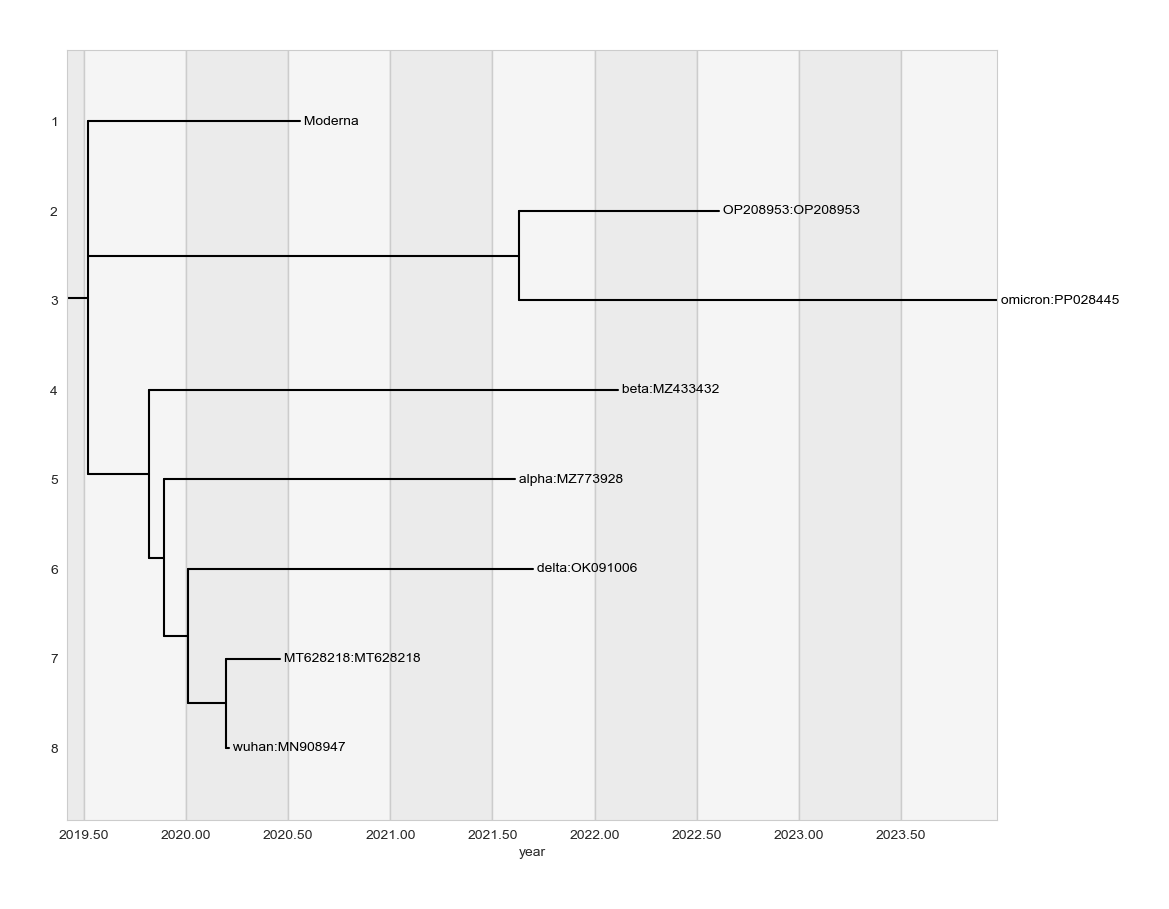

In [104]:
# Install TimeTree
!pip install timetree

from treetime import TreeTime
from treetime.utils import parse_dates

def format_axes(fig, axs):
    axs[0].set_axis_off()
    axs[1].tick_params(labelsize=14)
    axs[1].set_ylabel("root-to-tip distance", fontsize=16)
    axs[1].set_xlabel("date", fontsize=16)
    fig.tight_layout()

if __name__ == '__main__':

    # Load our alignment of COVID-19 variants
    plt.ion()
    base_name = 'covid_variants_aligned'

    # Parse the dates we converted to decimal years
    dates = parse_dates('metadata_dates.csv')
    
    # Choose the substitution model.  Jukes-Cantor is the most basic and fastes; it assumes 
    # equal substitution rates between all 4 nucleotides and no rate variation.  Others: HKY, GTR, etc.
    tt = TreeTime(gtr='Jukes-Cantor', tree = base_name+'.newick',
                  aln = base_name+'.afa', verbose = 1, dates = dates)

    # Rerooting can be done along with the tree time inference
    tt.run(root="best", branch_length_mode='input', max_iter=2)
    # if more complicated models (relaxed clocks, coalescent models) are to be used
    # or you want to resolve polytomies, treetime needs to be run for
    # several iterations, for example as
    #tt.run(root="best", resolve_polytomies=True, max_iter=2)

    # Convert the branch length to units in years and redraw
    tt.branch_length_to_years()
    Phylo.draw(tt.tree, label_func=lambda x:'', show_confidence=True, axes=axs[1])
    axs[1].set_title("Tree: units are years", fontsize=18)
    axs[0].tick_params(labelsize=14)
    axs[1].tick_params(labelsize=14)
    fig.tight_layout()

    # Plot tree along time axis (in decimal years) and label tips with strain names (exclude internal nodes) 
    from treetime.treetime import plot_vs_years
    plot_vs_years(tt, label_func=lambda x:x.name if x.is_terminal() else '', show_confidence=False)


Attempting to parse dates...
	Using column 'name' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

0.00	-TreeAnc: set-up

0.00	-SequenceData: loaded alignment.

0.00	-SeqData: making compressed alignment...

0.01	-SequenceData: constructed compressed alignment...
0.01	--ClockTree: Setting precision to level 1

0.01	-ClockTree._assign_dates: assigned date constraints to 7 out of 8 tips.

0.01	-TreeTime._set_branch_length_mode: maximum branch length is 1.293e-02,
    	 using branch length mode joint

0.01	-TreeAnc.optimize_tree: sequences...

0.01	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint
0.01	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
0.01	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
0.01	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
    	   likelihood sequences...
0.01	---TreeAnc._ml_anc_joint: ...done
0.01	--TreeAnc.infer_gtr: counting mutations...
0.02	---Tree

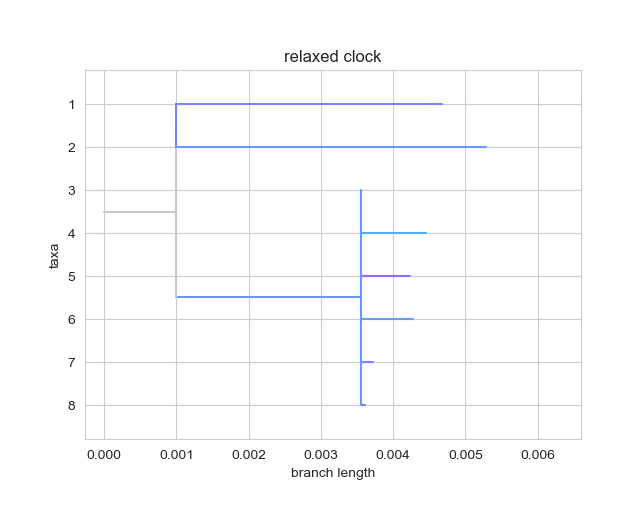

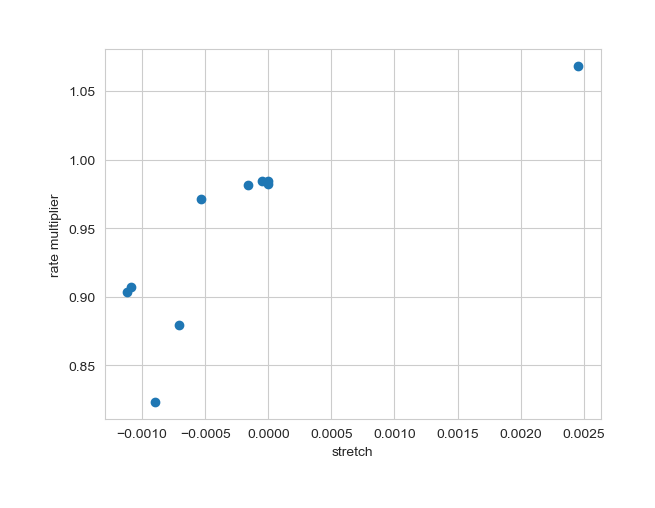

In [105]:
"""
This script illustrates the use of the relaxed clock model in TreeTime.
TreeTime currently only supports a normally distributed clock model.
"""

from __future__ import print_function, division
import sys

from treetime import TreeTime
from treetime.utils import parse_dates
import treetime.config as ttconf

if __name__ == '__main__':

    # Load the alignment and parse dates
    plt.ion()
    base_name = 'covid_variants_aligned'
    dates = parse_dates('metadata_dates.csv')

    # Instantiate treetime
    tt_relaxed = TreeTime(gtr='Jukes-Cantor', tree = base_name+'.newick',
                        aln = base_name+'.afa', verbose = 4, dates = dates)

    # This example uses an autocorrelated molecular clock with normal prior and parent-child coupling
    # the parameter slack penalizes rate deviations from the average rate
    # couplings penalize rate changes between parent and child nodes.
    tt_relaxed.run(root='best', relaxed_clock={"slack":5.0, "coupling":1.0}, max_iter=3,
                   resolve_polytomies=True, Tc=0, time_marginal=False)

    ##############
    # PLOTTING
    ##############

    # Draw trees inferred with the relaxed model
    fig = plt.figure()
    ax = plt.subplot(111)
    vmin, vmax = 0.5, 1.5 # color branches according to the rate deviation
    for n in tt_relaxed.tree.find_clades():
        if n.up:
            n.color = [int(x*255) for x in cm.cool((min(max(vmin, n.branch_length_interpolator.gamma),vmax)-vmin)/(vmax-vmin))[:3]]
        else:
            n.color = [200,200,200]

    ax.set_title("relaxed clock")
    Phylo.draw(tt_relaxed.tree, axes=ax, show_confidence=False, label_func = lambda x:'')

    # Scatter branch stretch against the rate multiplier of the branch.
    # They are expected to have a positive correlation
    # 1) Collect the optimal branch lenght (called mutation_length),
    #    the timetree branch length (clock_length) and the inferred rate multiplier gamma
    branch_lengths = []
    for n in tt_relaxed.tree.find_clades():
        if n.up:
            branch_lengths.append((n.mutation_length, n.clock_length, n.branch_length_interpolator.gamma))


    # 2) Plot the difference between optimal and timetree branch length vs the rate multiplier
    plt.figure()
    branch_lengths = np.array(branch_lengths)
    plt.scatter(branch_lengths[:,0]-branch_lengths[:,1], branch_lengths[:,2])
    plt.xlabel("stretch")
    plt.ylabel("rate multiplier")


the inferred sequences is an array of characters: ['C' 'C' 'C' ... 'C' 'C' 'T']

mutations on the branch leading to node Inner6: [('A', 35, 'C')]

mutation A35C corresponds to parent state: A, child state C




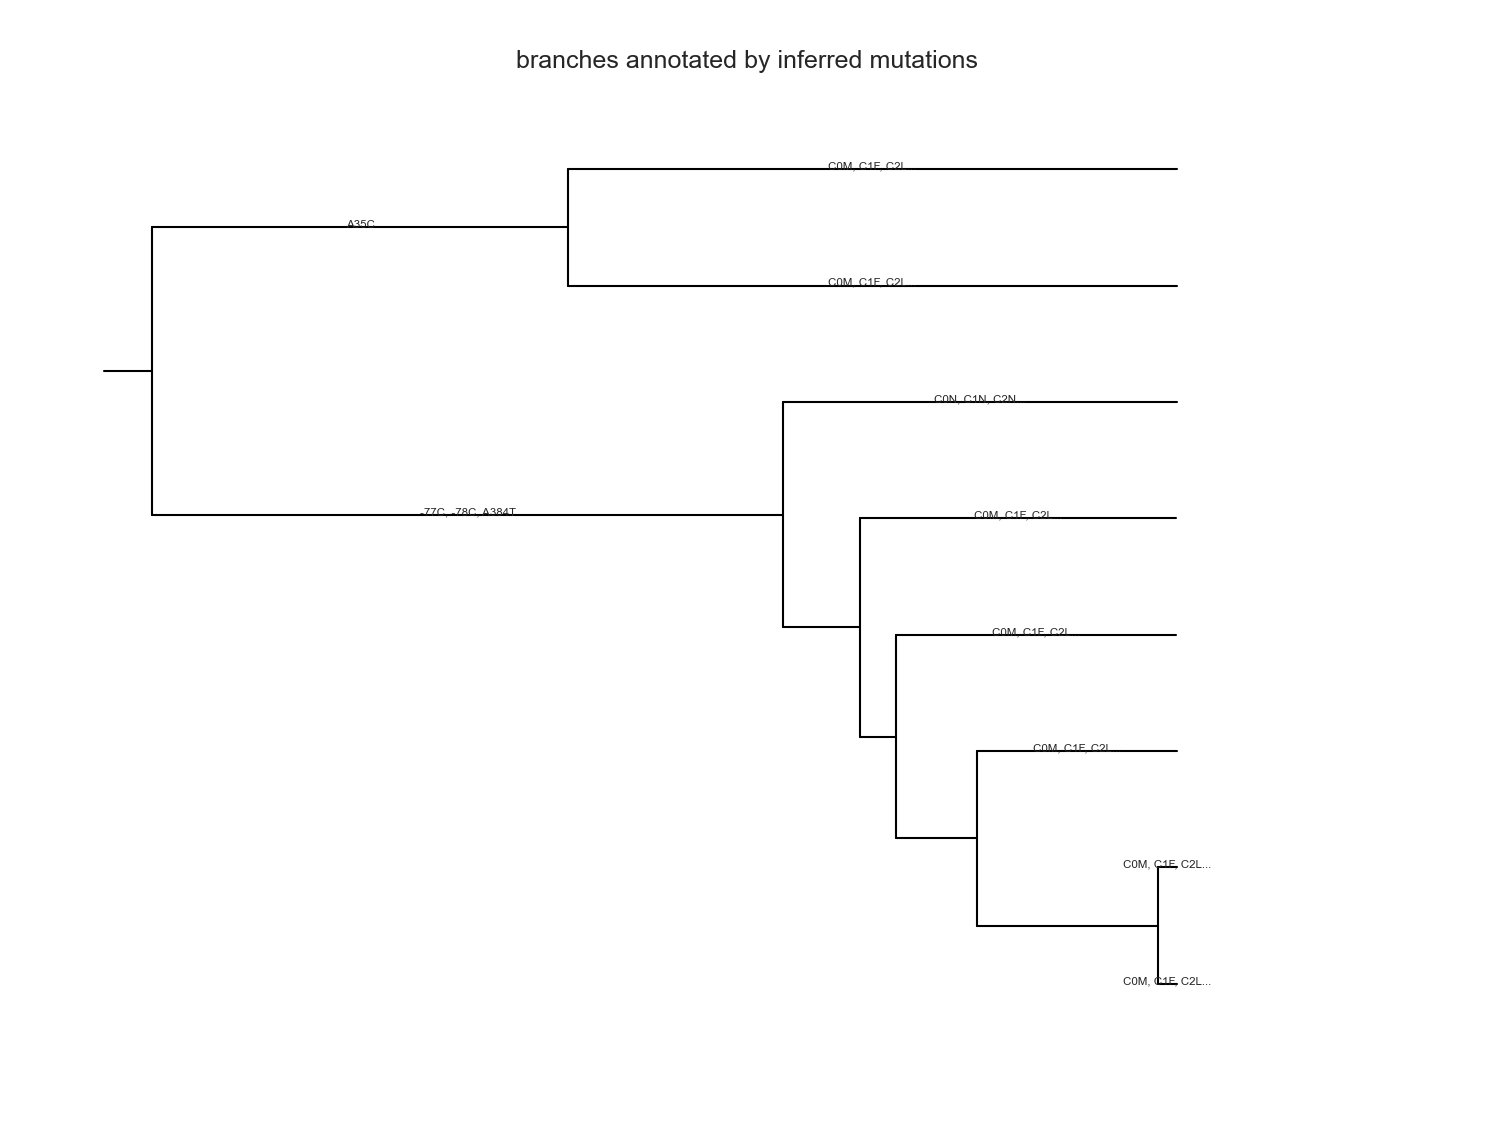

Substitution rate (mu): 1.0

Equilibrium frequencies (pi_i):
  A: 0.1262
  C: 0.3869
  G: 0.3138
  T: 0.1574
  -: 0.0156

Symmetrized rates from j->i (W_ij):
	A	C	G	T	-
  A	0	1.4797	1.7163	1.8971	1.3408
  C	1.4797	0	1.2486	1.287	1.2654
  G	1.7163	1.2486	0	1.5191	1.0377
  T	1.8971	1.287	1.5191	0	1.2079
  -	1.3408	1.2654	1.0377	1.2079	0

Actual rates from j->i (Q_ij):
	A	C	G	T	-
  A	0	0.1868	0.2167	0.2395	0.1693
  C	0.5725	0	0.4831	0.4979	0.4896
  G	0.5386	0.3918	0	0.4767	0.3256
  T	0.2987	0.2026	0.2392	0	0.1902
  -	0.021	0.0198	0.0162	0.0189	0



In [106]:
from treetime import TreeAnc
import treetime

if __name__ == '__main__':
    plt.ion()

    # Path to data
    base_name = 'covid_variants_aligned'

    # Instantiate treetime
    myTree = TreeAnc(gtr='Jukes-Cantor', tree=base_name+".newick", aln=base_name+'.afa', verbose = 0)

    # Infer a GTR model and ML ancestral sequences, either marginally or jointly most likely
    myTree.infer_ancestral_sequences(infer_gtr=True, marginal=True)

    # Lets examine the properties of a node in the tree after ancestral inference
    node = myTree.tree.get_nonterminals()[1]
    # Each node now has an inferred sequence
    if treetime.version<"0.7":
        print("\nthe inferred sequences is an array of characters:", node.sequence)
    else:
        print("\nthe inferred sequences is an array of characters:", myTree.sequence(node, as_string=False))

    # In addition, each node of the tree now has an mutation object attached
    # Note that the mutation numbering starts at 0 rather than 1
    print("\nmutations on the branch leading to node %s:"%node.name, node.mutations)

    # We can readily verify these mutations by checking the inferred sequences
    if node.mutations:
        mut = node.mutations[0]
        if treetime.version<"0.7":
            print("\nmutation %s%d%s corresponds to"%mut,
                  "parent state: %s, child state %s\n\n"%(node.up.sequence[mut[1]], node.sequence[mut[1]]))
        else:
            print("\nmutation %s%d%s corresponds to"%mut,
                  "parent state: %s, child state %s\n\n"%(myTree.sequence(node.up)[mut[1]], myTree.sequence(node)[mut[1]]))


    # Plot the tree and label branches by mutation
    fig, ax = plt.subplots(1,1,figsize=(18,13))
    ax.set_title("branches annotated by inferred mutations", fontsize=18)
    ax.set_axis_off()
    Phylo.draw(myTree.tree, label_func = lambda x:"", axes=ax,
        branch_labels=lambda x:", ".join(map(lambda m: "%s%d%s"%m, x.mutations[:3]))
                               +('...' if len(x.mutations)>3 else ""))

    # Finally, we print the inferred GTR model
    print(myTree.gtr)

**Challenge Questions!**

1) How many possible tree *topologies* (branching patterns, disregard branch lengths) are possible for a 4 taxa tree?

2) How many possible topologies are there for a 6 taxa tree?

In [118]:
from IPython.core.display import display, HTML

html = """
    Select an Image:
    <input type="radio" name="images" onclick="show1();" checked>Image 1</input>
    <input type="radio" name="images" onclick="show2();">Image 2</input>
    <input type="radio" name="images" onclick="show3();">Image 3</input>


    <div id="image1">
      <img src="Figures/4proteins_1tree.png">
    </div>
    <div id="image2">
      <img src="Figures/4proteins.png">
    </div>
    <div id="image3">
      <img src="Figures/6proteins.png">
    </div>
    
    <script>
    function show1(){
      document.getElementById('image1').style.display ='block';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
    }
    function show2(){
      document.getElementById('image2').style.display ='block';
      document.getElementById('image1').style.display ='none';
      document.getElementById('image3').style.display ='none';
    }
    function show3(){
      document.getElementById('image3').style.display ='block';
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
    }
    show1()
    </script>
"""
display(HTML(html))


Want to add some more variants to the plot.  See here for a much larger tree:
https://www.bv-brc.org/view/VariantLineage/#view_tab=phlyogeny